In [1]:
!pip install geopandas osmnx folium

In [2]:
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt

## Step 1: Data Preparation
โหลดข้อมูลสถานีขนส่งและขอบเขตพื้นที่ศึกษา

In [3]:
# ดึงขอบเขตจังหวัดนครปฐม
province = ox.geocode_to_gdf("Nakhon Pathom Province, Thailand")

province

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((99.81671 14.06916, 99.81861 14.06819...",99.816712,13.648575,100.337555,14.179124,238284513,relation,1908788,13.891842,100.016566,boundary,administrative,8,0.514337,province,Nakhon Pathom Province,"Nakhon Pathom Province, Thailand"


In [4]:
# ดึงขอบเขตอำเภอ
districts = ox.features_from_place(
    "Nakhon Pathom Province, Thailand",
    {"boundary": "administrative"}
)

# เลือกเฉพาะ level อำเภอ (admin_level = 6)
districts = districts[districts["admin_level"] == "6"]

districts = districts.to_crs(epsg=32647)

In [5]:
# ดึงข้อมูลสถานีขนส่ง
tags = {"amenity": "bus_station"}

stations = ox.features_from_place(
    "Nakhon Pathom Province, Thailand",
    tags
)

stations = stations.to_crs(province.crs)

stations.head()

geometry      amenity  \
element id                                                    
node    1034436175   POINT (99.99079 14.00409)  bus_station   
        1121789091  POINT (100.06145 13.82252)  bus_station   
        6474567385  POINT (100.05906 13.82339)  bus_station   
        9452373348  POINT (100.27861 13.78703)  bus_station   
        9753787535  POINT (100.26226 13.74601)  bus_station   

                                                               name  \
element id                                                            
node    1034436175                      Kamphaeng Saen Bus Terminal   
        1121789091  ท่ารถบริษัทมิตรภาพนครปฐมขนส่ง จำกัด (รถเมล์ขาว)   
        6474567385                                              NaN   
        9452373348                              ท่ารถเซ็นทรัลศาลายา   
        9753787535                                     อู่วัดไร่ขิง   

                        alt_name          name:en  bus public_transport  \
element id                                                                
node    1034436175           NaN              NaN  NaN              NaN   
        1121789091  ท่ารถเมล์ขาว              NaN  NaN              NaN   
        6474567385           NaN  Minivan station  NaN              NaN   
        9452373348           NaN              NaN  yes          station   
        9753787535           NaN              NaN  yes          station   

                   network operator addr:city addr:housenumber addr:postcode  \
element id                                                                     
node    1034436175     NaN      NaN       NaN              NaN           NaN   
        1121789091     NaN      NaN       NaN              NaN           NaN   
        6474567385     NaN      NaN       NaN              NaN           NaN   
        9452373348     NaN      NaN       NaN              NaN           NaN   
        9753787535    BMTA     BMTA       NaN              NaN           NaN   

                   access depot description industrial landuse name:th  \
element id                                                               
node    1034436175    NaN   NaN         NaN        NaN     NaN     NaN   
        1121789091    NaN   NaN         NaN        NaN     NaN     NaN   
        6474567385    NaN   NaN         NaN        NaN     NaN     NaN   
        9452373348    NaN   NaN         NaN        NaN     NaN     NaN   
        9753787535    NaN   NaN         NaN        NaN     NaN     NaN   

                   operator:short website  
element id                                 
node    1034436175            NaN     NaN  
        1121789091            NaN     NaN  
        6474567385            NaN     NaN  
        9452373348            NaN     NaN  
        9753787535            NaN     NaN

In [6]:
# เลือกเฉพาะข้อมูลที่จำเป็น
stations = stations[["name", "geometry"]].copy()

# ลบสถานีที่ไม่มีชื่อ
stations = stations.dropna(subset=["name"])

stations.head()


name  \
element id                                                              
node    1034436175                        Kamphaeng Saen Bus Terminal   
        1121789091    ท่ารถบริษัทมิตรภาพนครปฐมขนส่ง จำกัด (รถเมล์ขาว)   
        9452373348                                ท่ารถเซ็นทรัลศาลายา   
        9753787535                                       อู่วัดไร่ขิง   
way     1195052454  กลุ่มปฏิบัติการเดินรถที่ 1 เขตการเดินรถที่ 6 (...   

                                                             geometry  
element id                                                             
node    1034436175                          POINT (99.99079 14.00409)  
        1121789091                         POINT (100.06145 13.82252)  
        9452373348                         POINT (100.27861 13.78703)  
        9753787535                         POINT (100.26226 13.74601)  
way     1195052454  POLYGON ((100.26105 13.74609, 100.26228 13.746...

In [7]:
# แปลงเป็นระบบพิกัดเมตร
province_utm = province.to_crs(epsg=32647)
stations_utm = stations.to_crs(epsg=32647)

## Step 2: Buffer Analysis
สร้างพื้นที่ให้บริการรัศมี 5 กิโลเมตรรอบสถานี

In [8]:
# สร้าง buffer 5 km รอบสถานี
buffer_gdf = stations_utm.copy()
buffer_gdf["geometry"] = stations_utm.buffer(5000)


In [9]:
# รวม buffer ทุกสถานีเป็นพื้นที่เดียว
service_area = buffer_gdf.union_all() # Fix: Replaced .unary_union with .union_all()

service_area_gdf = gpd.GeoDataFrame(
    geometry=[service_area],
    crs=buffer_gdf.crs
)

# คำนวณพื้นที่ (ตารางกิโลเมตร)
area_sqkm = service_area_gdf.area.iloc[0] / 1_000_000

print("พื้นที่ให้บริการรวม (sq.km):", area_sqkm)

พื้นที่ให้บริการรวม (sq.km): 307.90211763958325


## Step 3: Spatial Join
วิเคราะห์ว่าสถานีอยู่ในพื้นที่ใด


In [10]:
# Spatial Join ระหว่างสถานีกับขอบเขตจังหวัด
joined = gpd.sjoin(stations_utm, province_utm, how="left", predicate="within")

print("จำนวนสถานีทั้งหมดในนครปฐม:", len(joined))

# ตรวจสอบ column
print(joined.columns)


จำนวนสถานีทั้งหมดในนครปฐม: 6
Index(['name_left', 'geometry', 'index_right', 'bbox_west', 'bbox_south',
       'bbox_east', 'bbox_north', 'place_id', 'osm_type', 'osm_id', 'lat',
       'lon', 'class', 'type', 'place_rank', 'importance', 'addresstype',
       'name_right', 'display_name'],
      dtype='object')


In [11]:
# นับจำนวนสถานีในแต่ละพื้นที่
count_by_area = joined.groupby("name_right").size().reset_index(name="station_count")

count_by_area


,name_right,station_count
0,Nakhon Pathom Province,6


## Step 4: Visualization

แสดงผลข้อมูลเชิงพื้นที่ด้วย Matplotlib (Static Map) และ Folium (Interactive Map)


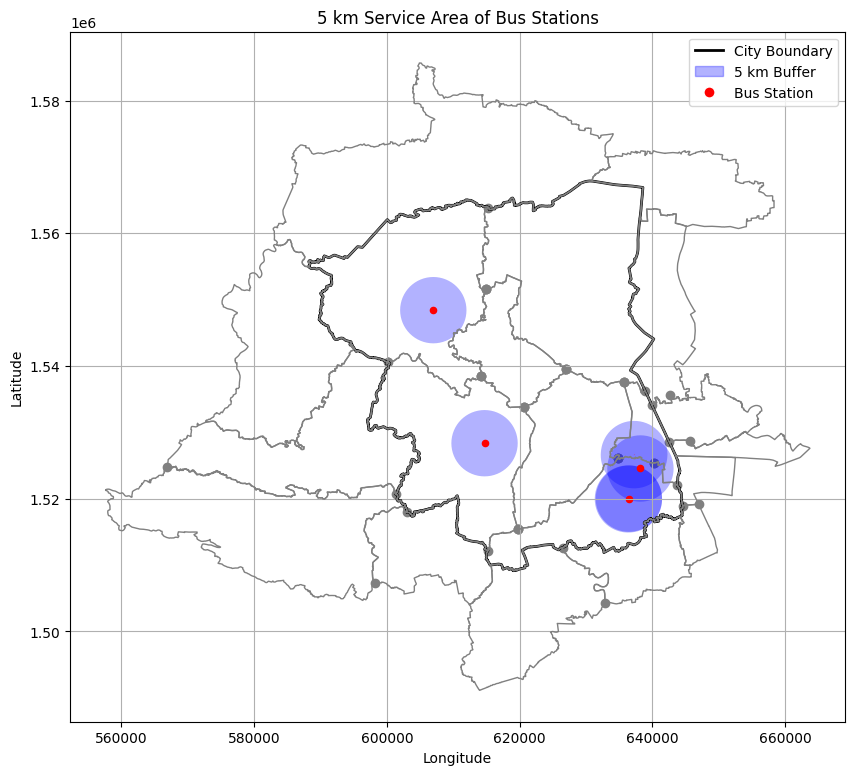

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

# City boundary (จังหวัด)
province_utm.boundary.plot(ax=ax, color="black", linewidth=2)

# District boundary (อำเภอ)
districts.boundary.plot(ax=ax, color="grey", linewidth=1)

# Buffer 5 km
buffer_gdf.plot(ax=ax, color="blue", alpha=0.3)

# Bus stations
stations_utm.plot(ax=ax, color="red", markersize=20)

# Legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='City Boundary'),
    Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='5 km Buffer'),
    Line2D([0], [0], marker='o', color='w', label='Bus Station',
           markerfacecolor='red', markersize=8)
]

ax.legend(handles=legend_elements, loc="upper right")

ax.set_title("5 km Service Area of Bus Stations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()

In [13]:
# แปลง CRS เป็น Lat/Long (WGS84)
province_wgs = province_utm.to_crs(epsg=4326)[["geometry"]].copy()
buffer_wgs = service_area_gdf.to_crs(epsg=4326)[["geometry"]].copy() # Fix: Replaced 'buffer_clip' with 'service_area_gdf'
stations_wgs = stations_utm.to_crs(epsg=4326)

# สร้างแผนที่
m = folium.Map(location=[13.8, 100.0], zoom_start=10)

# City Boundary
folium.GeoJson(
    province_wgs.to_json(),
    name="City Boundary",
    style_function=lambda x: {
        "color": "black",
        "weight": 2,
        "fillOpacity": 0
    }
).add_to(m)

# 5 km Buffer
folium.GeoJson(
    buffer_wgs.to_json(),
    name="5 km Buffer",
    style_function=lambda x: {
        "color": "blue",
        "fillColor": "blue",
        "weight": 1,
        "fillOpacity": 0.3
    }
).add_to(m)

# Bus Stations (เฉพาะ Point)
point_stations = stations_wgs[stations_wgs.geometry.geom_type == 'Point']

for idx, row in point_stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=1,
        popup=row.get("name", "Bus Station")
    ).add_to(m)

# Layer Control
folium.LayerControl().add_to(m)

m

**สรุปผลการเรียนรู้**

จากการทำแบบฝึกปฏิบัติครั้งนี้ ทำให้ได้เรียนรู้การใช้GeoPandas ในการจัดการและวิเคราะห์ข้อมูลเชิงพื้นที่ เช่น การนำเข้าข้อมูล การกำหนดระบบพิกัด (CRS) การแปลงพิกัด และการวิเคราะห์ข้อมูลเชิงพื้นที่ด้วยวิธี Buffer และ Spatial Join เพื่อศึกษาพื้นที่ให้บริการของสถานีขนส่งในจังหวัดนครปฐม

นอกจากนี้ยังได้เรียนรู้การสร้างแผนที่เพื่อแสดงผลข้อมูล โดยใช้ Matplotlib สำหรับแผนที่แบบภาพนิ่ง (static map) และ Folium สำหรับแผนที่แบบ Interactive ซึ่งสามารถซูมเข้า-ออกและเปิด-ปิดชั้นข้อมูลได้ ทำให้สามารถสำรวจข้อมูลได้สะดวกมากขึ้น

ซึ่งการใช้ Buffer ช่วยให้เข้าใจแนวคิดของพื้นที่ให้บริการรอบสถานีขนส่งในระยะที่กำหนด ส่วน Spatial Join ช่วยให้สามารถวิเคราะห์ได้ว่าสถานีขนส่งแต่ละแห่งอยู่ในพื้นที่ใด และสามารถนำไปใช้ในการวางแผนระบบคมนาคมหรือการให้บริการสาธารณะได้

โดยรวมแล้วทำให้เข้าใจขั้นตอนการวิเคราะห์ข้อมูลภูมิสารสนเทศตั้งแต่การเตรียมข้อมูล การประมวลผล จนถึงการแสดงผลแผนที่ และสามารถนำความรู้ไปประยุกต์ใช้กับงานด้านการวางแผนพื้นที่ในอนาคตไม่ว่าจะกับภาครัฐหรือภาคเอกชนได้

**คำถามท้าย Lab**

**1. อธิบายความแตกต่างระหว่าง Spatial Join และ Attribute**

ตอบ Spatial Join เป็นการเชื่อมข้อมูลโดยใช้ความสัมพันธ์เชิงพื้นที่ (ตำแหน่งภูมิศาสตร์) เช่น จุดอยู่ในพื้นที่ polygon หรืออยู่ใกล้กัน ส่วน Attribute Join เป็นการเชื่อมข้อมูลโดยใช้ค่าคอลัมน์ที่เหมือนกัน เช่น รหัสจังหวัดหรือชื่อพื้นที่

**2. ทำไมเราต้องแปลงระบบพิกัดก่อนใช้ buffer() ใน GeoPandas?**

ตอบเพราะการสร้าง buffer ต้องใช้หน่วยระยะทางจริง เช่น เมตร หรือกิโลเมตร หากใช้พิกัดแบบ Latitude/Longitude (องศา) ระยะที่ได้จะไม่ถูกต้อง ดังนั้นจึงต้องแปลงเป็นระบบพิกัดแบบ Projected Coordinate System เช่น UTM ก่อน เพื่อให้ขนาด buffer มีความแม่นยำ

**3. หากต้องการวิเคราะห์พื้นที่ให้บริการของสถานีขนส่งในระยะ 10 กิโลเมตร แทน 5 กิโลเมตร
ต้องแก้ไขส่วนใดของโค้ด?**

ตอบ ต้องแก้ไขค่าระยะ buffer ในขั้นตอน Buffer Analysis จากเดิม 5,000 เมตร เป็น 10,000 เมตร เนื่องจากหน่วยใน UTM เป็นเมตร

**4. วิธีใดที่เหมาะสมที่สุดในการแสดงผลข้อมูลเชิงพื้นที่ในรูปแบบ Interactive Map? เพราะเหตุใด?**

ตอบ การใช้ Folium เหมาะสมที่สุดสำหรับ Interactive Map เพราะสามารถซูมเข้า-ออก เปิด-ปิด layer และดูข้อมูลรายละเอียดของตำแหน่งต่าง ๆ ได้ ทำให้ผู้ใช้สามารถสำรวจข้อมูลเชิงพื้นที่ได้ง่ายกว่าการแสดงผลแบบ static map

**5. หากพบว่า Buffer ที่สร้างมีขนาดไม่ถูกต้อง อาจเกิดจากสาเหตุใดได้บ้าง?
และสามารถแก้ไขได้อย่างไร?**

ตอบ สาเหตุที่เป็นไปได้ เช่น

1.ใช้ระบบพิกัดแบบองศา (WGS84) ก่อนทำ buffer *วิธีแก้ไขคือ*
แปลง CRS เป็นระบบ Projected เช่น UTM ก่อนทำ buffer

2.ใช้หน่วยระยะทางผิด เช่น ใส่ค่า 5 แทน 5000 *วิธีแก้ไขคือ* ตรวจสอบหน่วยระยะทางให้ถูกต้อง (เมตร)

3.CRS ของข้อมูลแต่ละชั้นไม่ตรงกัน *วิธีแก้ไขคือ* ตรวจสอบให้ทุก layer ใช้ CRS เดียวกัน